# Cirrhosis Outcome Prediction


# Import our packages

In [36]:
# Import core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# import our models
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
)
from sklearn.metrics import log_loss
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    StackingClassifier,
    VotingClassifier,
)
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

In [37]:
# Create our palette
palette = sns.color_palette(
    [
        "#86C2DA",
        "#D0C1AA",
        "#D98594",
        "#C0DDE1",
        "#E9DBD0",
        "#8E8C8F",
        "#9A9AA2",
    ],
)
# Create a diverging palette from our original palette
div_palette = sns.color_palette("blend:#86C2DA,#D98594")

# Set the base palette as default
sns.set_palette(palette)

# Read our Data

In [38]:
# read in the data
test = pd.read_csv("./data/test.csv")
train = pd.read_csv("./data/train.csv")

We can also standardize our column headers in order to make them more efficient to work with

In [39]:
def clean_column_labels(df):
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    return df

In [40]:
train = clean_column_labels(train)
test = clean_column_labels(test)

Lets take a look at our train dataset

In [41]:
train.head()

,id,n_days,drug,age,sex,ascites,hepatomegaly,spiders,edema,bilirubin,cholesterol,albumin,copper,alk_phos,sgot,tryglicerides,platelets,prothrombin,stage,status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


# Data Exploration

In order to get a better undestanding of the dataset we are working with we will conduct an exploritory analysis of the dataset.<br>
The target variables for our analysis, and eventually our models will be the `status` variable which indicates the status of patients as one of three options:
- C: Censored
- CL: Censored and liver transplant
- D: Death

The values will be formed into a distribution and plotted as a histogram. The values of the categorical variables of the dataset will be plotted using a countplot.

## Overview

The train dataset contains 7905 rows and 20 columns. The test dataset contains 5271 rows and 19 columns.

Neither dataset contains any null values which allows us to jump directly into our exploratory analysis without the need imputing prior. 

The exploration will be done primarily with the train dataset, however the two datasets will be compared in order to determine if the distribution of categorical variables is similar between both datasets. 

##### We have three types of variables in ourdata set: Categorical, Numeric, and Descriptive.<br>

The descriptive variables in our data set are:
- `id`: Patient ID

The categorical variables in our data set are:
- `drug`: Drug used for treatment
- `sex`: Sex of the patient (M/F)
- `ascites`: Presence of Ascites (N/Y)
- `hepatomegaly`: Presence of hepatomegaly (N/Y)
- `spiders`: Presence of spiders (N/Y)
- `edema`: Presence of edema
- `status`: Status of patient
- `stage`: histological stage of disease

The numeric variables in our data set are:
- `age`: Age of patient
- `bilirubin`: Bilirubin levels
- `cholesterol`: Cholesterol levels
- `albumin`: Albumin levels
- `copper`: Urine copper levels
- `alk_phos`: Alkaline phosphotase levels
- `sgot`: SGOT levels
- `triglicerides`: Trigliceride levels
- `platelets`: Platelet levels
- `prothrombin`: Prothrombin activity


In [42]:
# Find the number of nulls in the dataset
train_nulls = train.isnull().sum().sum()
test_nulls = test.isnull().sum().sum()

print(
    f"There are {train_nulls} nulls in the train dataset and {test_nulls} nulls in the test dataset."
)

There are 0 nulls in the train dataset and 0 nulls in the test dataset.


We can drop the `id` column at this point since it does not provide and useful information for our models. We can also create lists of our categorical and numeric column names

In [43]:
# drop id
train.drop("id", axis=1, inplace=True)
test.drop("id", axis=1, inplace=True)

# Find our categorical and numeric variables
cat_vars = list(train.select_dtypes(include=["object"]).columns)
num_vars = list(train.select_dtypes(exclude=["object"]).columns)

## Target Variable

c:\Users\Matt\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Matt\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Matt\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_

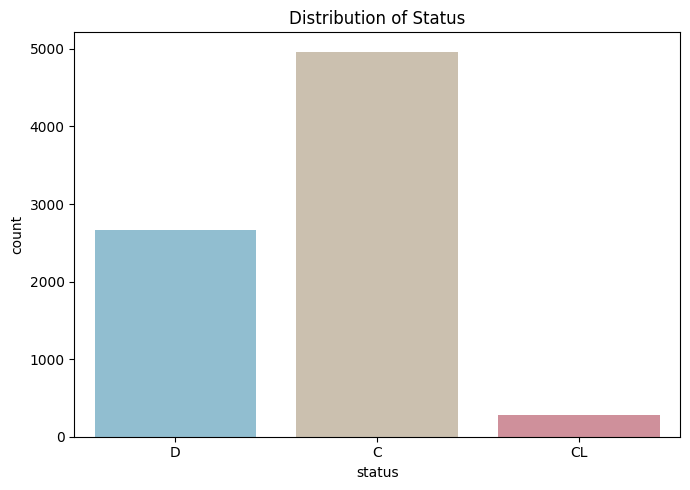

In [44]:
plt.figure(figsize=(7, 5))
sns.countplot(
    data=train, x="status", hue="status", legend=False, palette=palette[:3]
)
plt.title("Distribution of Status")
plt.tight_layout()
plt.show()

The target variable for our analysis will be the `status` variable which indicates the status of patients as one of three options: C, CL, D

Based on the count plot generated for our data we are able to see that our training data set has a higher number of patients who were censored than those who died. This is important to note as it will affect the way we evaluate our models. The lowest number of patients are those who were censored and received a liver transplant. This may be a result of the fact that the data was collected from a hospital in the United States where the cost of a liver transplant is very high and transplant lists are long.

Based on these findings we would expect that our model would predict a higher number of patients to be censored than to die, assuming that our testing dataset has a similar distribution of data to our training set. This is something we will need to keep in mind when evaluating our models.

## Categorical Variables

We will take a look at each categorical variable by creating a count plot of each value for each variable. We can also compare the distribution of values for each categorical variables between our train and test dataset. It is important to ensure that there is a similar distribution between our test and train datasets, especially when there rare so many categorical variables.

c:\Users\Matt\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Matt\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Matt\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_

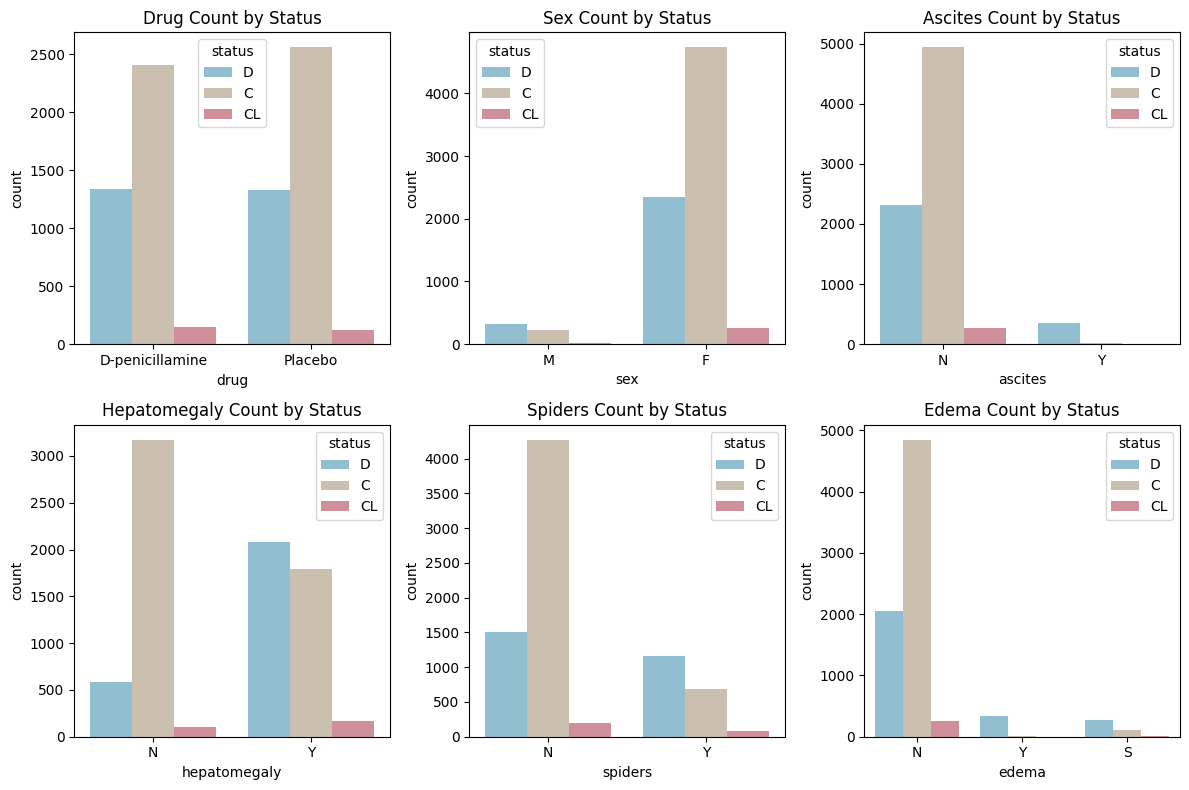

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    sns.countplot(
        data=train, hue="status", x=cat_vars[i], ax=ax, palette=palette[:3]
    )
    ax.set_title(f"{cat_vars[i].title()} Count by Status")
plt.tight_layout()
plt.show()

#### Drug
Based on the class of drug in our dataset we can see that there is a similar distribution of status between the two drug categories. This is important to note as it indicates that the drug used for treatment does not have a significant impact on the status of the patient.

#### Sex
The sex variable in our dataset reveals that there is a greater number of females compared to males in our dataset. It is important to note that this may effect the reliability of our model to accurately predict outcomes for males in future data. 

Based off of our distribution we are able to see that the largest number of male patients have the status of death, which differs from the largest number of having the status of censored for a majority of the other variables

#### Hepatomegaly, Spiders, Edema, Ascites
For the four testing conditions for Cirhosis, we can see that those which were indicated as having the presence (These variables are indicated as having or not having the condition) were more likely to have the status of death compared to the other three status options. This is important to note as it indicates that the presence of these conditions may be a good indicator of the status of the patient.


## Numeric Variables

Now we can take a look at our numeric variables. First we will investigate the distributions of the numeric variables, and then we can look at the relationship between the numeric variables and our target variable.

c:\Users\Matt\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Matt\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\Matt\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Matt\AppData\Local\Programs\Python\Python311\Lib

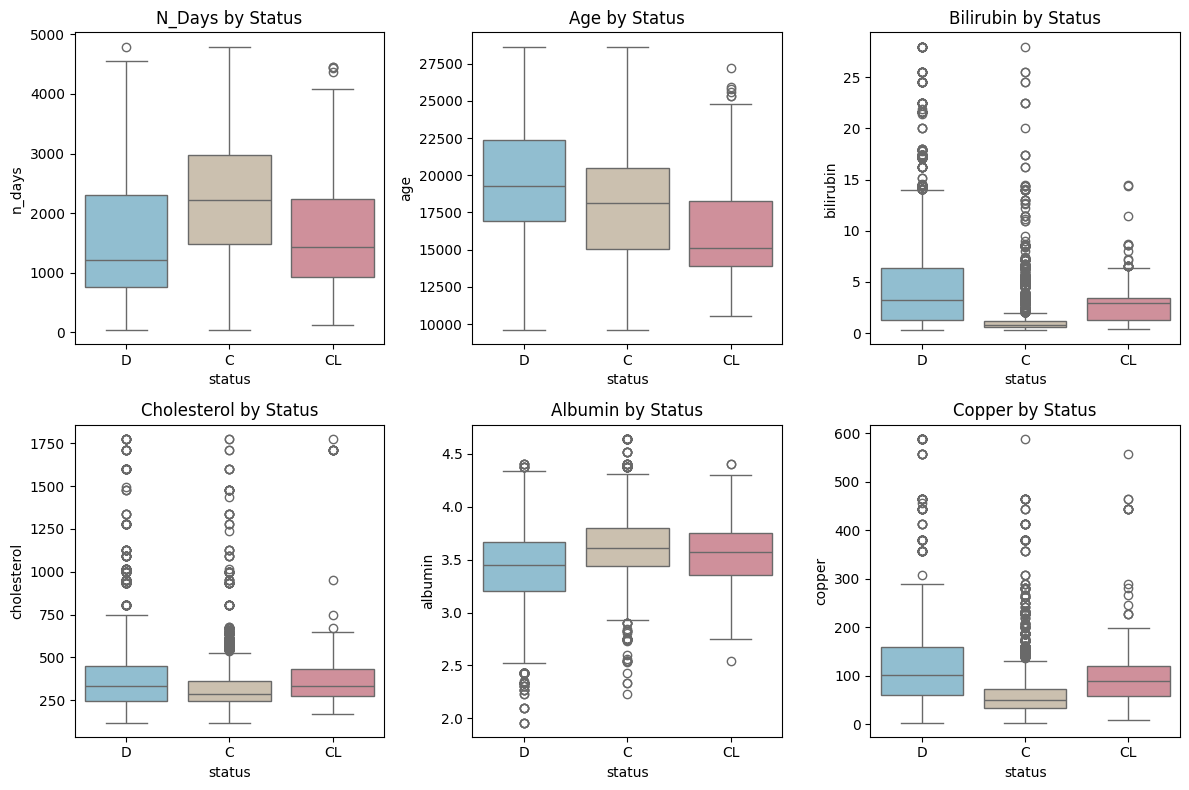

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(
        data=train,
        x="status",
        hue="status",
        y=num_vars[i],
        legend=False,
        ax=ax,
        palette=palette[:3],
    )
    ax.set_title(f"{num_vars[i].title()} by Status")
plt.tight_layout()
plt.show()

#### Age
The age variable reveals that the patients with the death status are more likely to be older than those with the censored status. This is important to note as it indicates that age may be a good indicator of the status of the patient. Additionally, patients receiving liver transplants are more likely to be younger than those who died.

#### Billirubin
Our analysis revealed that average Billirubin for patients with the status of death is higher than those with the status of censored. This is important to note as it indicates that Billirubin may be a good indicator of the status of the patient.

#### Cholesterol
Cholesterol level distributions were similar among all three status options.

#### Copper
Copper level distributions were similar to those of Billirubin. The average copper level for patients with the status of death is higher than those with the status of censored. This is important to note as it indicates that copper levels may be a good indicator of the status of the patient.



# Model Building


## Feature and Target Selection

The target for this analysis is the `status` column, which indicates the status of the patient. This will be selected as our target, and the other variables in our dataset will be selected as our features.


In [47]:
X = train.copy().drop(columns=["status"], axis=1)
y = train.copy()["status"].map(
    {"C": 0, "CL": 1, "D": 2}
)  ## TODO Potentialy map these to numeric values

## Model Evaluation

We will be using **4** main models for this analysis:
- RandomForestClasifier
- AdaBoost
- CatBoost
- XGBoost

Each of the four models will be created and evaluated using our training dataset. 

These models will then be used in a series on model ensembles and compared. These ensembles include using a stacking classifier with a sklearn neural net classifier as the final estimator, and a voting classifier which ways the  outcomes of the 4 main models. 

The best performing model will be used to predict the outcomes of the test dataset.

In [48]:
# Four main models
xgb = XGBClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
cat = CatBoostClassifier(random_state=42)

# Secondary ensemble models
mlp = MLPClassifier()
stack = StackingClassifier(
    estimators=[("rf", rf), ("ada", ada), ("cat", cat), ("xgb", xgb)],
    final_estimator=mlp,
)
voting = VotingClassifier(
    estimators=[("rf", rf), ("ada", ada), ("cat", cat), ("xgb", xgb)],
    voting="soft",
)

## Pipeline Creation

We will start by creating a preprocessing pipeline which will be used to transform our data prior to modeling. This pipeline will be used to transform both our training and test datasets.

In [49]:
num_vars = list(X.select_dtypes(exclude=["object"]).columns)
cat_vars = list(X.select_dtypes(include=["object"]).columns)

In [50]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_vars),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_vars),
    ]
)

We used the robust scaler from scikit learn in order to scale our data. Scaling our data is crucial in order to get good results because it creates more reliability amongst our values. We also encoded our categorical values using OneHotEncoder. This is important because it allows us to use our categorical variables in our models.

In [51]:
base_models = [("rf", rf), ("ada", ada), ("cat", cat), ("xgb", xgb)]

We can start by preprocessing our training dataset. We wll then use to prepped data to pass into each of our four base models. The results will be evaluated and the best performing model will be used to predict the outcomes of the test dataset. We will be testing the log loss of each model.

In [52]:
X_prep = preprocess.fit_transform(X)

## Hyperparameter Tuning

We can use hyperparameter tuning in order to improve the performance of our models. We will be using the GridSearchCV function from scikit learn in order to tune our models. A small grid of parameters have been created for our three best preforming models: RandomForestClassifier, CatBoostClassifier, and XGBClassifier.

In [53]:
# Hyperparameter dictionary with parameters for each model
param_grid = {
    "rf": {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "xgb": {
        "booster": ["gbtree", "gblinear", "dart"],
        "learning_rate": [0.01, 0.1, 0.3],
    },
    "cat": {
        "boosting_type": ["Ordered", "Plain"],
        "learning_rate": [0.01, 0.1, 0.3],
    },
    "ada": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.3],
    },
}

We will conduct our GridSearch then store the best hyperparameters for each model, which we will then use later to create our model ensembles.

In [54]:
tuning_results = {}  # Create a dictionary to store our results

# Initialize our grid search
for model in base_models:
    # Establish our gridsearch with each model
    grid = GridSearchCV(
        model[1], param_grid[model[0]], scoring="neg_log_loss", cv=5, n_jobs=-1
    )
    # Fit our gridsearch
    grid.fit(X_prep, y)
    # Store the results in a dictionary
    tuning_results[model[0]] = {}
    tuning_results[model[0]]["grid"] = grid
    tuning_results[model[0]]["best_params"] = grid.best_params_
    tuning_results[model[0]]["best_score"] = grid.best_score_

0:	learn: 0.9990791	total: 33.2ms	remaining: 33.2s
1:	learn: 0.9243496	total: 104ms	remaining: 51.7s
2:	learn: 0.8616668	total: 168ms	remaining: 55.8s
3:	learn: 0.8107694	total: 233ms	remaining: 58s
4:	learn: 0.7654257	total: 300ms	remaining: 59.6s
5:	learn: 0.7287350	total: 372ms	remaining: 1m 1s
6:	learn: 0.6977561	total: 451ms	remaining: 1m 3s
7:	learn: 0.6711966	total: 528ms	remaining: 1m 5s
8:	learn: 0.6482396	total: 614ms	remaining: 1m 7s
9:	learn: 0.6284840	total: 713ms	remaining: 1m 10s
10:	learn: 0.6114349	total: 810ms	remaining: 1m 12s
11:	learn: 0.5958031	total: 877ms	remaining: 1m 12s
12:	learn: 0.5825621	total: 946ms	remaining: 1m 11s
13:	learn: 0.5705350	total: 1.01s	remaining: 1m 11s
14:	learn: 0.5593313	total: 1.08s	remaining: 1m 11s
15:	learn: 0.5501582	total: 1.15s	remaining: 1m 10s
16:	learn: 0.5401780	total: 1.23s	remaining: 1m 11s
17:	learn: 0.5318642	total: 1.31s	remaining: 1m 11s
18:	learn: 0.5250553	total: 1.39s	remaining: 1m 11s
19:	learn: 0.5195905	total: 1.47

The results of our hyperparameter search can be converted into a table and seen below:

In [55]:
# Put results into a dataframe
tuning_results_df = pd.DataFrame(tuning_results).T
tuning_results_df

,grid,best_params,best_score
rf,"GridSearchCV(cv=5, estimator=RandomForestClass...","{'max_depth': 10, 'min_samples_leaf': 2, 'n_es...",-0.46779
ada,"GridSearchCV(cv=5, estimator=AdaBoostClassifie...","{'learning_rate': 0.01, 'n_estimators': 50}",-0.618495
cat,"GridSearchCV(cv=5,\n estimator=<ca...","{'boosting_type': 'Ordered', 'learning_rate': ...",-0.455224
xgb,"GridSearchCV(cv=5,\n estimator=XGB...","{'booster': 'dart', 'learning_rate': 0.1}",-0.45752


In [56]:
# Update hyperparameters of base models with best results
for model in base_models:
    model[1].set_params(**tuning_results_df.loc[model[0], "best_params"])

## Model Testing
We can make a function which we can use to test each of base models using a stratified kfold cross validation. This will allow us to get a better idea of how each model performs on our dataset. We will also be able to see how the models perform on different splits of the data.

In [57]:
def test_model(model, model_name, X, y):
    """
    Test a model using cross validation and return the average log loss score, and the trained model
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    models = []
    for train_idx, test_idx in cv.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_test)
        scores.append(log_loss(y_test, preds))
        models.append(model)
    print(f"{model_name} CV Log Loss: {np.mean(scores)}")
    return (models, scores)

In [58]:
# Create a dictionary to store our trained models and scores
model_results = {}
for name, model in base_models:
    results = test_model(model, name, X_prep, y)
    model_results[name] = {}
    model_results[name]["models"] = results[0]
    model_results[name]["scores"] = results[1]

rf CV Log Loss: 0.4675867450516803
ada CV Log Loss: 0.6179611116107404
0:	learn: 0.9960572	total: 38.1ms	remaining: 38.1s
1:	learn: 0.9202457	total: 73.4ms	remaining: 36.6s
2:	learn: 0.8601011	total: 110ms	remaining: 36.5s
3:	learn: 0.8099145	total: 145ms	remaining: 36s
4:	learn: 0.7673155	total: 180ms	remaining: 35.9s
5:	learn: 0.7318624	total: 218ms	remaining: 36.2s
6:	learn: 0.7014871	total: 256ms	remaining: 36.3s
7:	learn: 0.6744427	total: 298ms	remaining: 36.9s
8:	learn: 0.6514169	total: 336ms	remaining: 37s
9:	learn: 0.6310616	total: 380ms	remaining: 37.6s
10:	learn: 0.6132892	total: 418ms	remaining: 37.6s
11:	learn: 0.5992426	total: 458ms	remaining: 37.7s
12:	learn: 0.5871234	total: 484ms	remaining: 36.7s
13:	learn: 0.5746496	total: 523ms	remaining: 36.9s
14:	learn: 0.5643728	total: 560ms	remaining: 36.8s
15:	learn: 0.5556392	total: 601ms	remaining: 37s
16:	learn: 0.5462295	total: 640ms	remaining: 37s
17:	learn: 0.5383092	total: 677ms	remaining: 36.9s
18:	learn: 0.5321301	total:

We can now use the collection of models and score we have generated in order to create an ensemble using the best models;

In [59]:
# Create a list of best models for each classifier
best_models = []
for classifier in model_results:
    best_models.append(
        (
            classifier,
            model_results[classifier]["models"][
                np.argmin(model_results[classifier]["scores"])
            ],
        )
    )

Based on our preliminary results our best model was the CatBoostClassifier at a log loss of 0.46. Our worst model was the AdaBoostClassifier at a log loss of 1.051.

Since the AdaBoostClassifier performed so poorly we will not be using it in our model ensembles.

In [60]:
best_models.pop(1)

('ada', AdaBoostClassifier(learning_rate=0.01, random_state=42))

## Stacking Classifier Ensemble

We will start by creating a stacking classifier ensemble. This will use a neural net classifier as the final estimator. We will use the best performing models from our previous analysis as the base estimators.

In [61]:
# Instantiate our stacking classifier
stk = StackingClassifier(estimators=best_models, cv=5, final_estimator=mlp)

We can then update our models in the stacking classifier to use the best hyperparameter determined by the grid search.

In [62]:
# Fit our stacking classifier
stk.fit(X_prep, y)

0:	learn: 0.9990791	total: 24.3ms	remaining: 24.3s
1:	learn: 0.9243496	total: 75.2ms	remaining: 37.5s
2:	learn: 0.8616668	total: 124ms	remaining: 41.4s
3:	learn: 0.8107694	total: 170ms	remaining: 42.2s
4:	learn: 0.7654257	total: 213ms	remaining: 42.4s
5:	learn: 0.7287350	total: 264ms	remaining: 43.7s
6:	learn: 0.6977561	total: 323ms	remaining: 45.8s
7:	learn: 0.6711966	total: 373ms	remaining: 46.3s
8:	learn: 0.6482396	total: 421ms	remaining: 46.4s
9:	learn: 0.6284840	total: 470ms	remaining: 46.5s
10:	learn: 0.6114349	total: 525ms	remaining: 47.2s
11:	learn: 0.5958031	total: 577ms	remaining: 47.5s
12:	learn: 0.5825621	total: 624ms	remaining: 47.4s
13:	learn: 0.5705350	total: 670ms	remaining: 47.2s
14:	learn: 0.5593313	total: 727ms	remaining: 47.7s
15:	learn: 0.5501582	total: 799ms	remaining: 49.1s
16:	learn: 0.5401780	total: 857ms	remaining: 49.5s
17:	learn: 0.5318642	total: 909ms	remaining: 49.6s
18:	learn: 0.5250553	total: 967ms	remaining: 49.9s
19:	learn: 0.5195905	total: 1.02s	remai

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=2,
                                                       n_estimators=300,
                                                       random_state=42)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x000002E39F902850>),
                               ('xgb',
                                XGBClassifier(base_score=None, booster='dart',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              ear...
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=MLPClassifier())

In [63]:
y_pred = stk.predict_proba(X_prep)
score = log_loss(y, y_pred)
print(f"Stacking Classifier Log Loss: {score}")

Stacking Classifier Log Loss: 0.23941435482625925


### Voting Classifier

Lets also create a voting classifier using our best models. We will use the RandomForestClassifier, CatBoostClassifier, and XGBClassifier. We will use the voting classifier results and compare them to our stacking classifier results.

In [64]:
# Instantiate our voting classifier
voting = VotingClassifier(estimators=best_models, voting="soft", n_jobs=-1)

In [65]:
# Fit our voting classifier
voting.fit(X_prep, y)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_leaf=2,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x000002E39F902850>),
                             ('xgb',
                              XGBClassifier(base_score=None, booster='dart',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stop...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 n_jobs=-1, voting='soft')

In [66]:
# Predict on our training data
y_pred = voting.predict_proba(X_prep)
score = log_loss(y, y_pred)
print(f"Voting Classifier Log Loss: {score}")

Voting Classifier Log Loss: 0.25197070403283855


c:\Users\Matt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


While both ensemble models performed better than our base models, our stacking classifier performed better than our voting classifier. This is likely due to the fact that the stacking classifier uses a neural net classifier as the final estimator, which is a more complex model than the voting classifier. Having two models which preformed better than our base models will allow us to generate two sets of predictions for our test dataset. We can then compare the results of the two models and use the best performing model to predict the outcomes of our test dataset.

# Submission

We will generate our submission by reading in the provided sample submission and overriding the classification probabilities with those generated by our models. 

In [67]:
submission = pd.read_csv("./data/sample_submission.csv")
submission.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.628084,0.034788,0.337128
1,7906,0.628084,0.034788,0.337128
2,7907,0.628084,0.034788,0.337128
3,7908,0.628084,0.034788,0.337128
4,7909,0.628084,0.034788,0.337128


Our X_test will just be our trained data put through the preprocessing pipeline. We can then use our best model to predict the outcomes of the test dataset.


In [68]:
X_test = preprocess.transform(test)

We will then pass this to our trained model and predict the outcomes of the test dataset. We can then create a submission file and submit it to Kaggle.

In [69]:
y_pred = stk.predict_proba(X_test)

In [70]:
submission.iloc[:, 1:] = y_pred
submission.to_csv("./data/submission.csv", index=False)

We will also create a section submission using our voting clsasifier and compare the results.

In [71]:
y_pred = voting.predict_proba(X_test)

In [72]:
submission.iloc[:, 1:] = y_pred
submission.to_csv("./data/submission2.csv", index=False)